In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

#warnings
import warnings
warnings.filterwarnings('ignore')

#***Load The Zip File Dataset:-***

In [68]:
#load File dataset
zip_path = '/content/logic_leap_horizon_datasets.zip'   # your zip file path
extract_to = '/content/logic_leap_datasets'             # where to extract

# Create folder and extract
os.makedirs(extract_to, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(" Extracted to:", extract_to)

 Extracted to: /content/logic_leap_datasets


#***check the file in the zip folder:-***

In [69]:
os.listdir(extract_to)


['operations_daily_28d.csv',
 'operations_daily_60d.csv',
 'operations_daily_30d.csv',
 'operations_daily_120d.csv',
 'operations_daily_14d.csv',
 'operations_daily_180d.csv',
 'operations_daily_365d.csv',
 'operations_daily_45d.csv',
 'operations_daily_150d.csv',
 'site_meta.csv',
 'operations_daily_7d.csv',
 'operations_daily_270d.csv',
 'operations_daily_90d.csv']

#***Combine all 13 CSVs***:-

In [70]:
# path to the extracted folder
folder = "/content/logic_leap_datasets"

# get all daily csv files
files = [f for f in os.listdir(folder) if f.startswith("operations_daily") and f.endswith(".csv")]

dfs = []
for f in files:
    path = os.path.join(folder, f)
    df = pd.read_csv(path)
    dfs.append(df)

# combine
ops = pd.concat(dfs, ignore_index=True)
ops = ops.drop_duplicates()

# parse and sort
ops['date'] = pd.to_datetime(ops['date'])
ops = ops.sort_values(['site_id', 'date']).reset_index(drop=True)

In [71]:
ops.head()

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag
0,2025-01-01,S1,1169,71,4201,14,404,53,71.97,96.13,20.7,0.0,0
1,2025-01-01,S1,1258,44,4119,21,430,57,72.10,95.85,21.7,0.0,0
2,2025-01-01,S1,1313,54,4625,38,611,54,71.92,95.99,22.0,0.0,0
3,2025-01-01,S1,1392,77,4815,31,455,52,72.12,95.78,22.8,0.0,0
4,2025-01-01,S1,1152,29,3733,29,426,53,72.38,95.91,22.5,0.0,0


In [72]:
print(" Combined shape:", ops.shape)

 Combined shape: (5432, 13)


#***Save the Combine file:-***

In [73]:
#save the full file
ops.to_csv('/content/operations_daily_full.csv', index=False)

#***Combine site_meta data in with operational dataset:-***

In [74]:
meta = pd.read_csv("/content/site_meta.csv")

In [75]:
meta

,site_id,region,commissioned_year,shift_hours_per_day
0,S1,South,2018,20
1,S2,West,2016,24
2,S3,North,2020,16
3,S4,East,2015,20


In [76]:
# Merge by site_id
data = ops.merge(meta, on="site_id", how="left")

In [77]:
data.head()

,date,site_id,units_produced,downtime_minutes,power_kwh,rework_units,defects_ppm,staff_count,material_cost_per_unit,price_per_unit,temperature_c,rainfall_mm,holiday_flag,region,commissioned_year,shift_hours_per_day
0,2025-01-01,S1,1169,71,4201,14,404,53,71.97,96.13,20.7,0.0,0,South,2018,20
1,2025-01-01,S1,1258,44,4119,21,430,57,72.10,95.85,21.7,0.0,0,South,2018,20
2,2025-01-01,S1,1313,54,4625,38,611,54,71.92,95.99,22.0,0.0,0,South,2018,20
3,2025-01-01,S1,1392,77,4815,31,455,52,72.12,95.78,22.8,0.0,0,South,2018,20
4,2025-01-01,S1,1152,29,3733,29,426,53,72.38,95.91,22.5,0.0,0,South,2018,20


In [78]:
#Shape of dataset
data.shape

(5432, 16)

#***EDA(Explotary Data Analysis):-***

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5432 entries, 0 to 5431
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    5432 non-null   datetime64[ns]
 1   site_id                 5432 non-null   object        
 2   units_produced          5432 non-null   int64         
 3   downtime_minutes        5432 non-null   int64         
 4   power_kwh               5432 non-null   int64         
 5   rework_units            5432 non-null   int64         
 6   defects_ppm             5432 non-null   int64         
 7   staff_count             5432 non-null   int64         
 8   material_cost_per_unit  5432 non-null   float64       
 9   price_per_unit          5432 non-null   float64       
 10  temperature_c           5432 non-null   float64       
 11  rainfall_mm             5432 non-null   float64       
 12  holiday_flag            5432 non-null   int64   

In [80]:
# Descriptive statistics (numeric columns)
data.describe().T

,count,mean,min,25%,50%,75%,max,std
date,5432,2025-04-17 14:50:43.298969088,2025-01-01 00:00:00,2025-02-02 00:00:00,2025-03-24 00:00:00,2025-06-08 00:00:00,2025-12-31 00:00:00,NaN
units_produced,5432.0,1206.471834,0.0,1119.0,1270.0,1421.0,1904.0,373.010722
downtime_minutes,5432.0,61.607327,0.0,40.0,55.0,69.0,368.0,49.342179
power_kwh,5432.0,4279.676178,0.0,3967.75,4458.0,4966.0,8052.0,1353.139323
rework_units,5432.0,26.58542,0.0,22.0,27.0,33.0,52.0,10.06876
defects_ppm,5432.0,421.129971,0.0,373.0,442.0,505.0,774.0,142.623667
staff_count,5432.0,51.503866,0.0,50.0,55.0,58.0,68.0,14.540896
material_cost_per_unit,5432.0,66.582885,0.0,69.98,71.4,72.2,73.92,17.778093
price_per_unit,5432.0,89.747353,0.0,94.5675,96.04,97.36,99.81,23.967272
temperature_c,5432.0,25.981222,18.0,22.4,24.5,29.7,36.7,4.392549


In [81]:
# Check null values
data.isnull().sum()

,0
date,0
site_id,0
units_produced,0
downtime_minutes,0
power_kwh,0
rework_units,0
defects_ppm,0
staff_count,0
material_cost_per_unit,0
price_per_unit,0


In [82]:
#check the duplicate row
data.duplicated().sum()

np.int64(0)

In [83]:
#check the column rain has empty or any data present in this column
data['rainfall_mm'].unique()

array([ 0. ,  2.8,  2.5,  2.3,  1. ,  3.5,  1.2,  0.7,  2.4,  1.7,  3. ,
        2. ,  2.9,  4.6,  4.4,  1.6,  3.9,  1.1,  6.5,  0.4,  0.5,  1.8,
        0.8,  5.3,  2.1,  0.3,  0.1,  3.1,  3.2,  0.6,  4.7,  4.2,  1.4,
        1.5,  5.9,  0.9,  1.3,  8.9,  0.2,  4.5,  3.4,  7.6,  3.3, 13.8,
        5.1,  5.8, 10.3,  8.3,  6.3, 11. , 11.3,  6.6,  6.4,  6. ,  2.6,
        2.7,  8.7,  7.7,  5.7,  4.3,  9. ,  5.6,  4.1, 17.9,  5. ,  7. ,
        2.2,  4.9,  8.1,  1.9, 12.7,  3.8, 10.6,  9.3,  5.2])

In [84]:
print("\nColumn Names:", data.columns.tolist())


Column Names: ['date', 'site_id', 'units_produced', 'downtime_minutes', 'power_kwh', 'rework_units', 'defects_ppm', 'staff_count', 'material_cost_per_unit', 'price_per_unit', 'temperature_c', 'rainfall_mm', 'holiday_flag', 'region', 'commissioned_year', 'shift_hours_per_day']


In [85]:
# Unique Site IDs
print("\nSites:", data['site_id'].unique())


Sites: ['S1' 'S2' 'S3' 'S4']


S1 → South

S2 → West

S3 → North

S4 → East

In [86]:
# Check region unique per site
print(data.groupby('site_id')['region'].unique())

site_id
S1    [South]
S2     [West]
S3    [North]
S4     [East]
Name: region, dtype: object


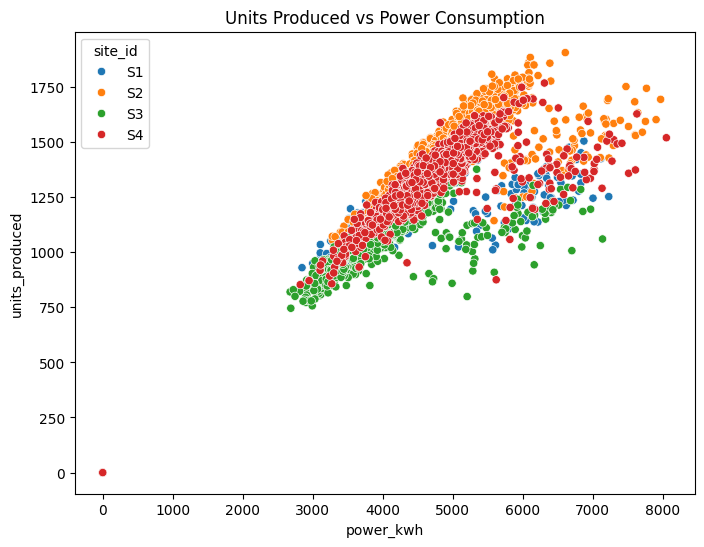

In [87]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='power_kwh', y='units_produced', hue='site_id', data=data)
plt.title("Units Produced vs Power Consumption")
plt.show()


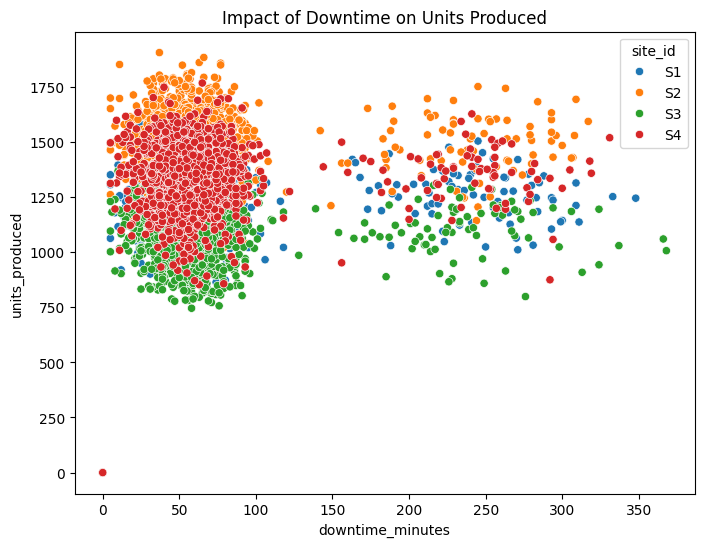

In [88]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='downtime_minutes', y='units_produced', hue='site_id', data=data)
plt.title("Impact of Downtime on Units Produced")
plt.show()


#***Feature Engineerings:-***

In [89]:
data['site_age'] = 2025 - data['commissioned_year']
data['units_per_hour'] = data['units_produced'] / data['shift_hours_per_day']
data['power_per_unit'] = data['power_kwh'] / data['units_produced']

In [90]:
data['day_of_week'] = data['date'].dt.dayofweek

In [91]:
data['month'] = data['date'].dt.month

In [92]:
#check is there any null vales after feature engineering
data.isnull().sum()

,0
date,0
site_id,0
units_produced,0
downtime_minutes,0
power_kwh,0
rework_units,0
defects_ppm,0
staff_count,0
material_cost_per_unit,0
price_per_unit,0


In [93]:
#drop the null values
data.dropna(inplace=True)

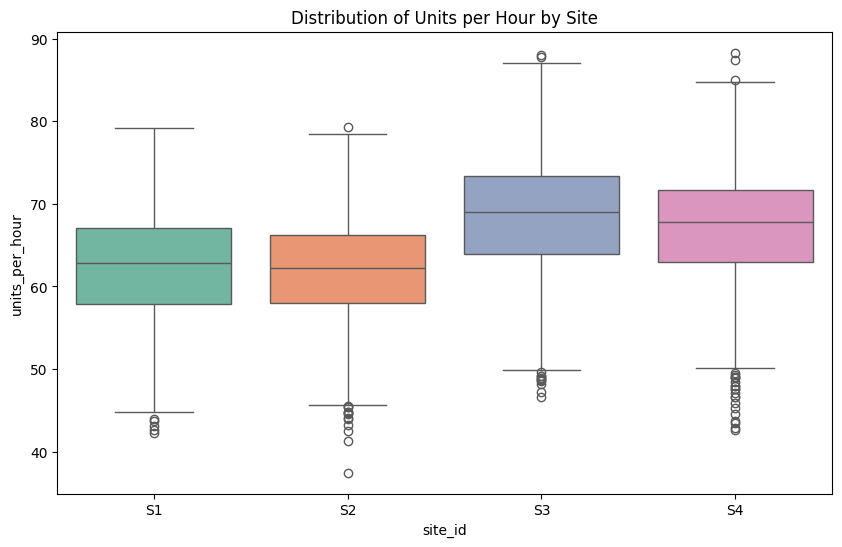

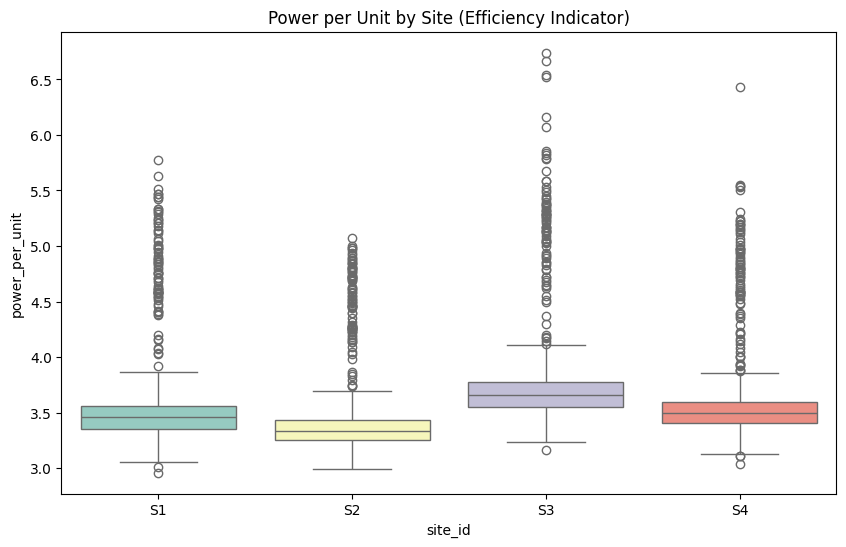

In [94]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='site_id', y='units_per_hour', data=data, palette='Set2')
plt.title("Distribution of Units per Hour by Site")
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='site_id', y='power_per_unit', data=data, palette='Set3')
plt.title("Power per Unit by Site (Efficiency Indicator)")
plt.show()


#**`Environmental Effects:-`**

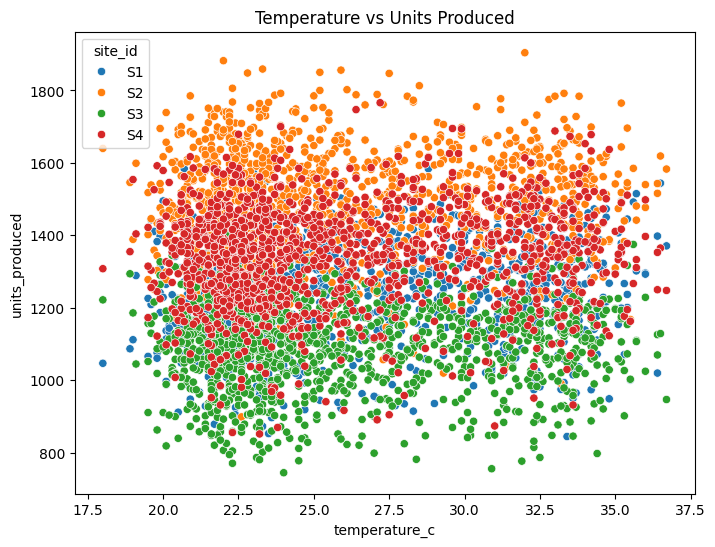

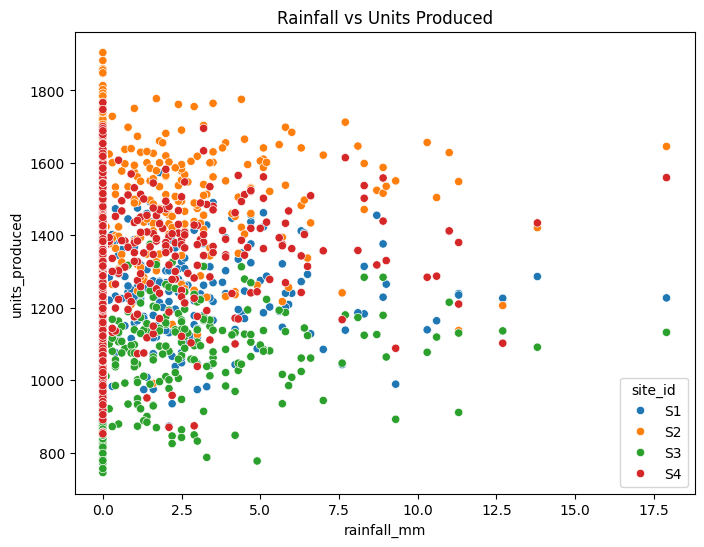

In [95]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='temperature_c', y='units_produced', hue='site_id', data=data)
plt.title("Temperature vs Units Produced")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='rainfall_mm', y='units_produced', hue='site_id', data=data)
plt.title("Rainfall vs Units Produced")
plt.show()


#`Cost & Pricing Insights:-`

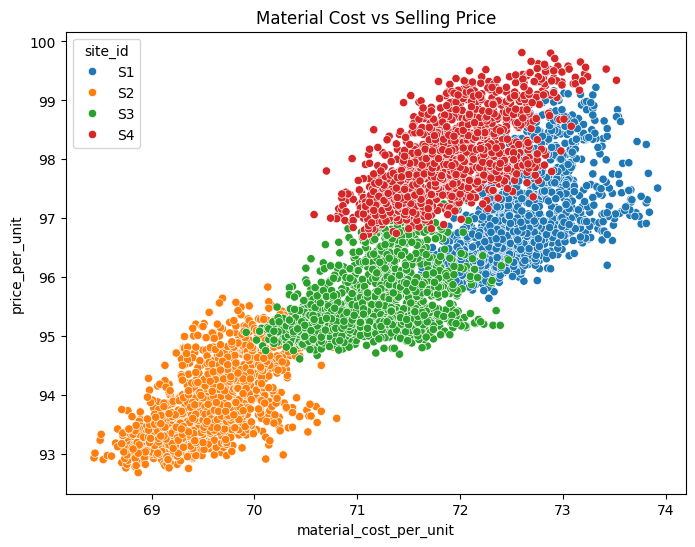

In [96]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='material_cost_per_unit', y='price_per_unit', hue='site_id', data=data)
plt.title("Material Cost vs Selling Price")
plt.show()


#*`Categorical Feature Insights:-`*

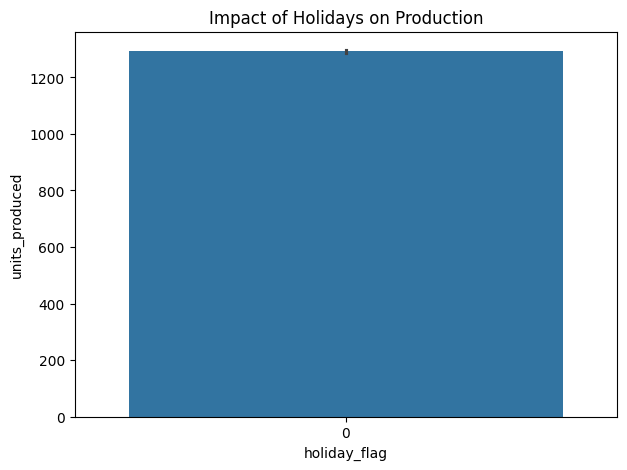

In [97]:
plt.figure(figsize=(7, 5))
sns.barplot(x='holiday_flag', y='units_produced', data=data)
plt.title("Impact of Holidays on Production")
plt.show()


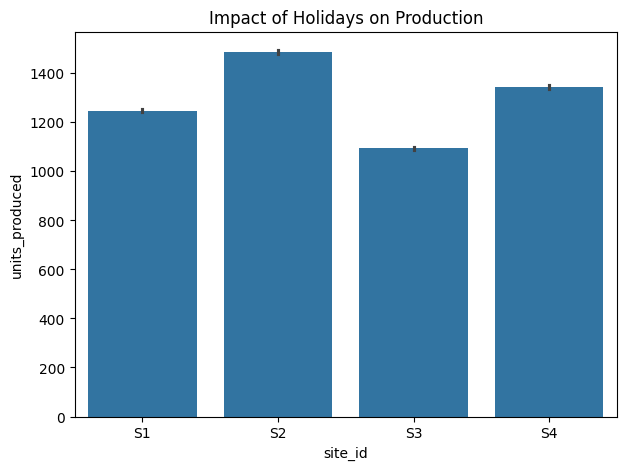

In [98]:
plt.figure(figsize=(7, 5))
sns.barplot(x='site_id', y='units_produced', data=data)
plt.title("Impact of Holidays on Production")
plt.show()


In [99]:
# Select main numeric columns for analysis
num_cols = [
    'units_produced', 'power_kwh', 'downtime_minutes',
    'rework_units', 'defects_ppm', 'staff_count',
    'material_cost_per_unit', 'price_per_unit',
    'temperature_c', 'rainfall_mm'
]

#`Compare region wise all column comparision:-`

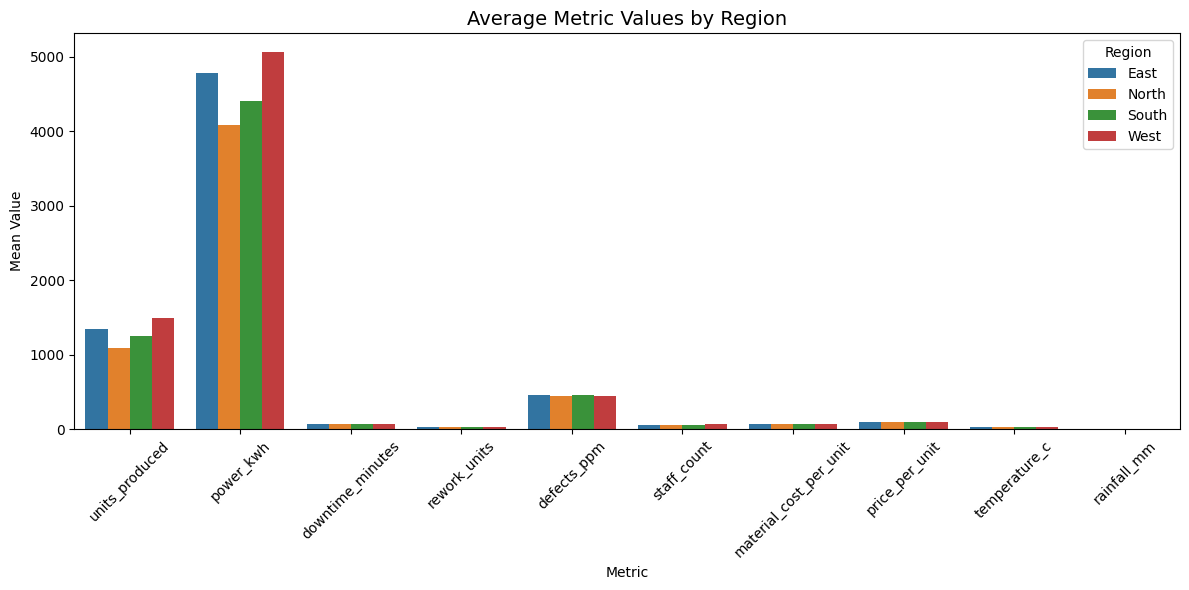

In [100]:
# Average comparison across regions
region_means = data.groupby('region')[num_cols].mean().reset_index()

plt.figure(figsize=(12,6))
sns.barplot(data=region_means.melt(id_vars='region', var_name='Metric', value_name='Mean_Value'),
            x='Metric', y='Mean_Value', hue='region')
plt.xticks(rotation=45)
plt.title("Average Metric Values by Region", fontsize=14)
plt.ylabel("Mean Value")
plt.xlabel("Metric")
plt.legend(title='Region')
plt.tight_layout()
plt.show()

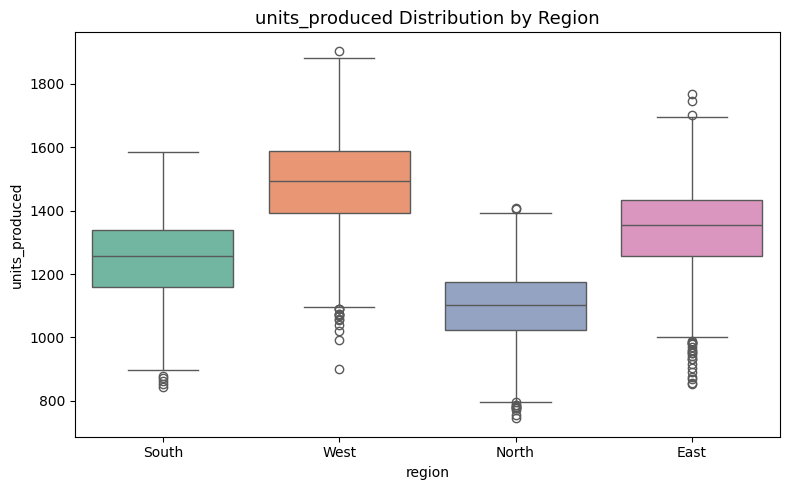

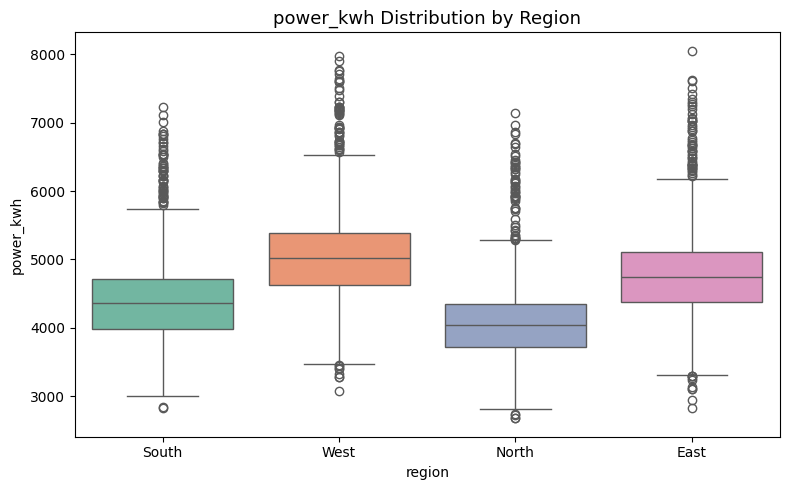

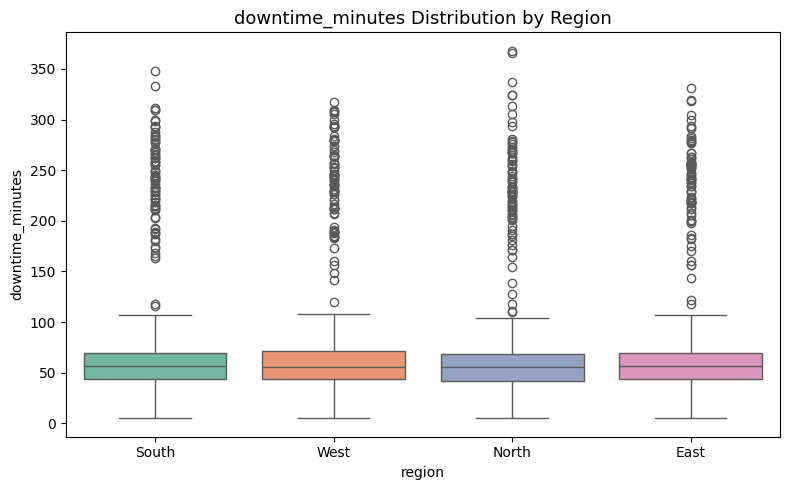

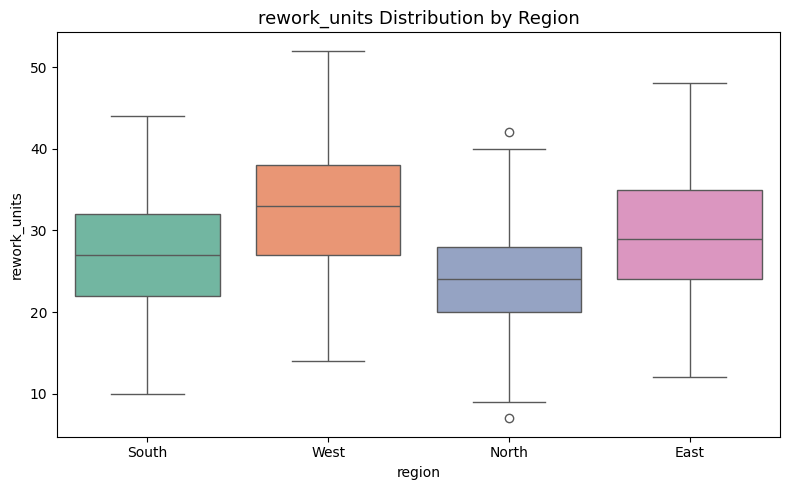

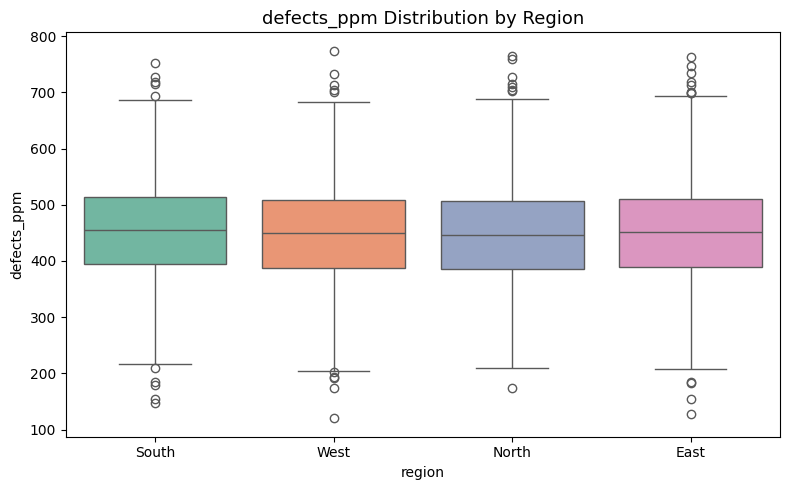

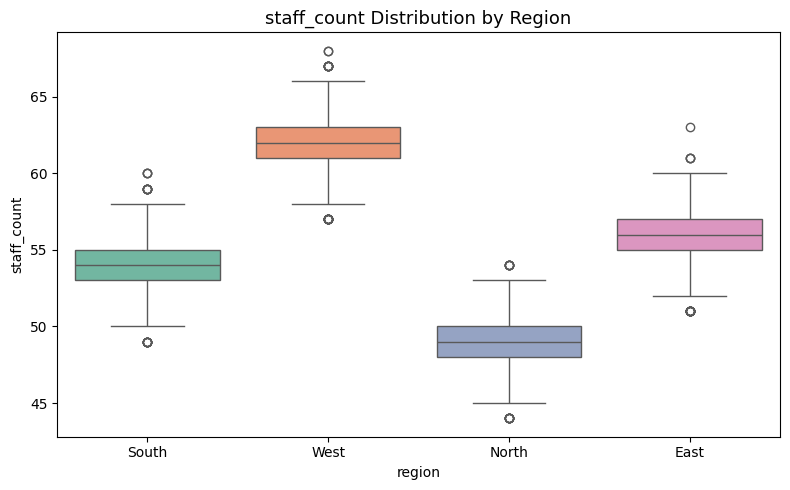

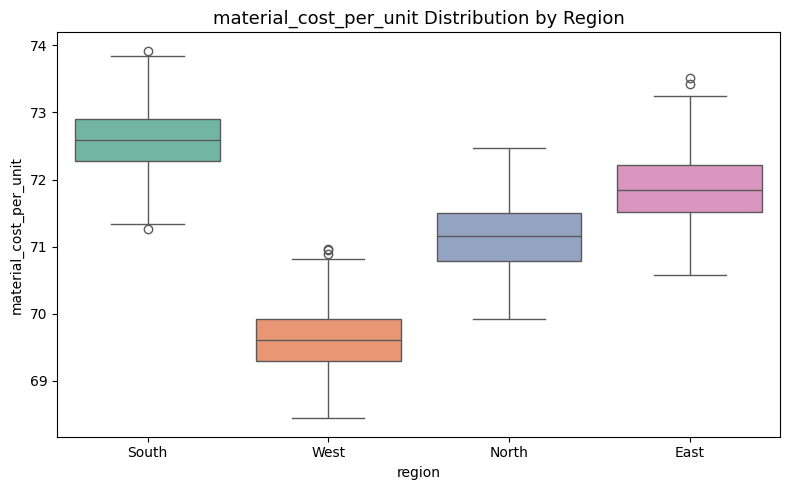

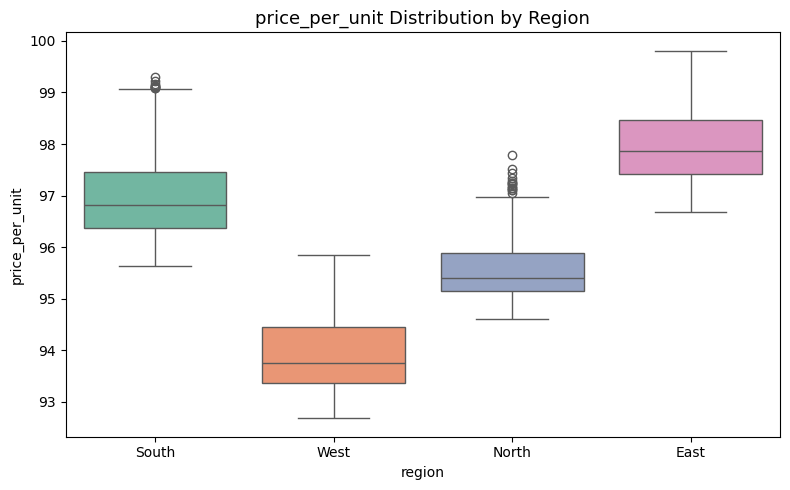

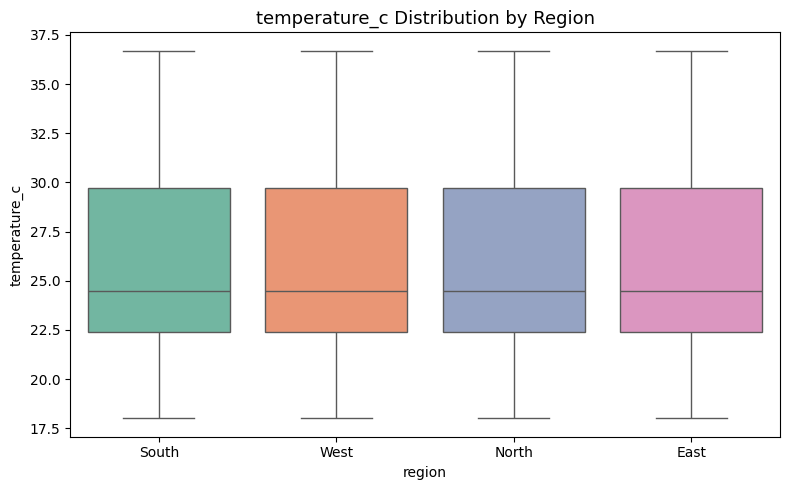

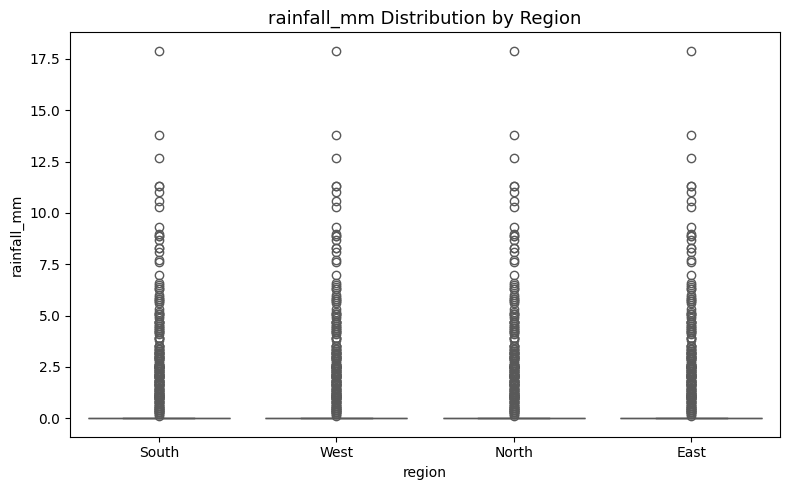

In [101]:
for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='region', y=col, data=data, palette='Set2')
    plt.title(f"{col} Distribution by Region", fontsize=13)
    plt.tight_layout()
    plt.show()


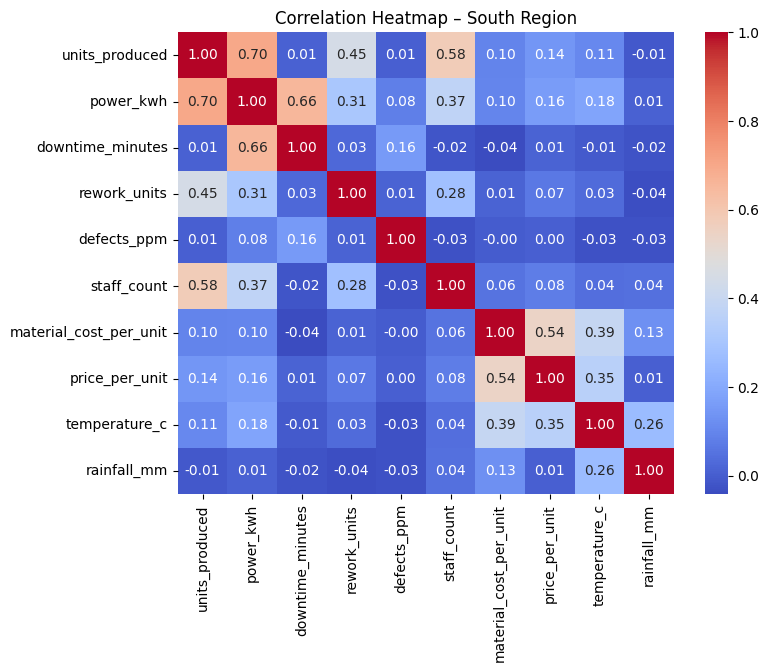

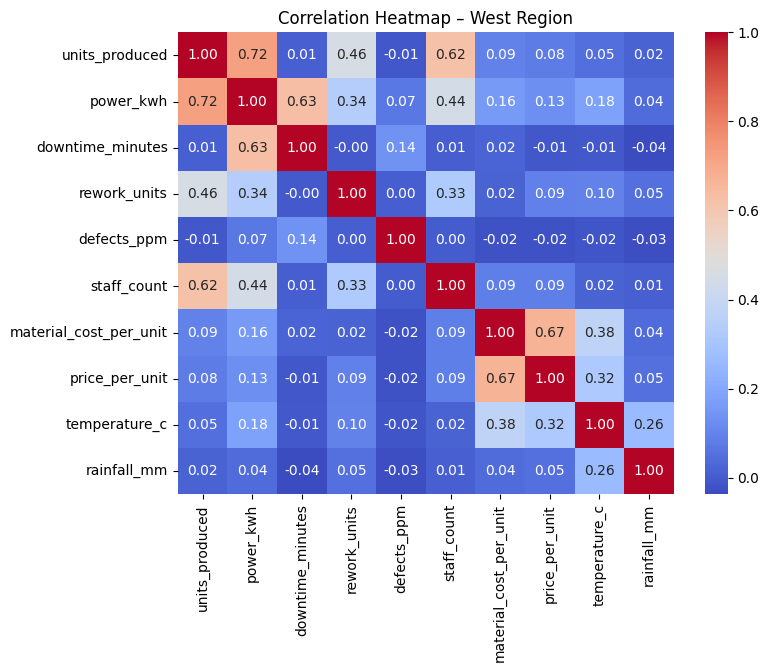

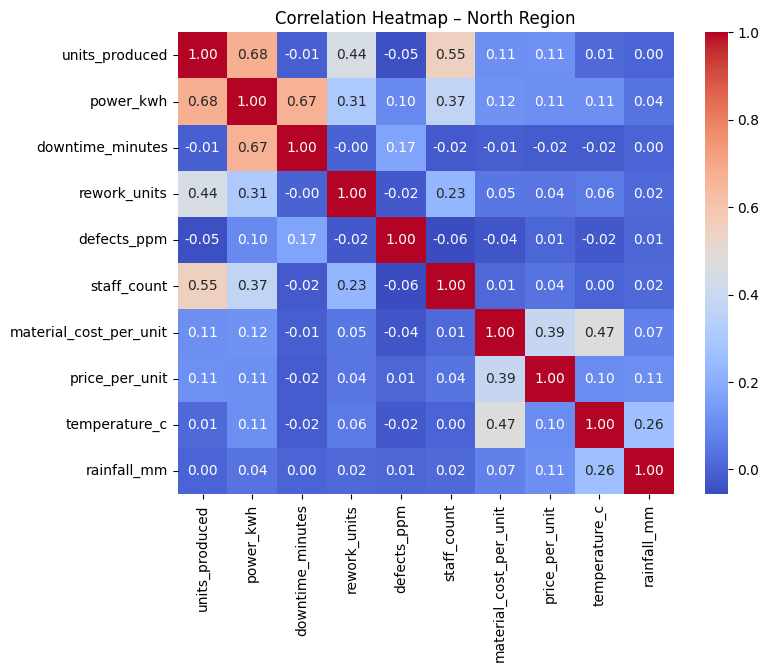

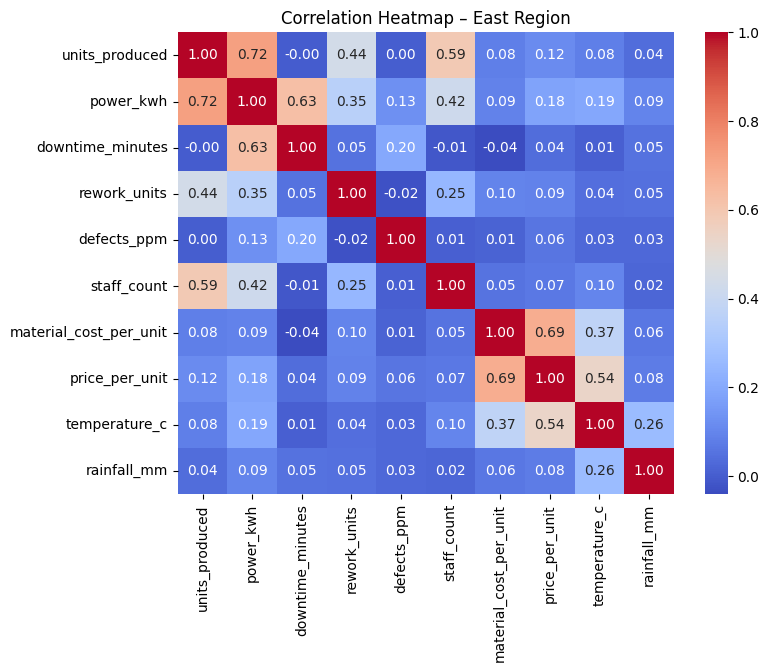

In [102]:
regions = data['region'].unique()

for r in regions:
    subset = data[data['region'] == r]
    corr = subset[num_cols].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"Correlation Heatmap – {r} Region")
    plt.show()


#`Timeline graph on region unit production & power production:-`

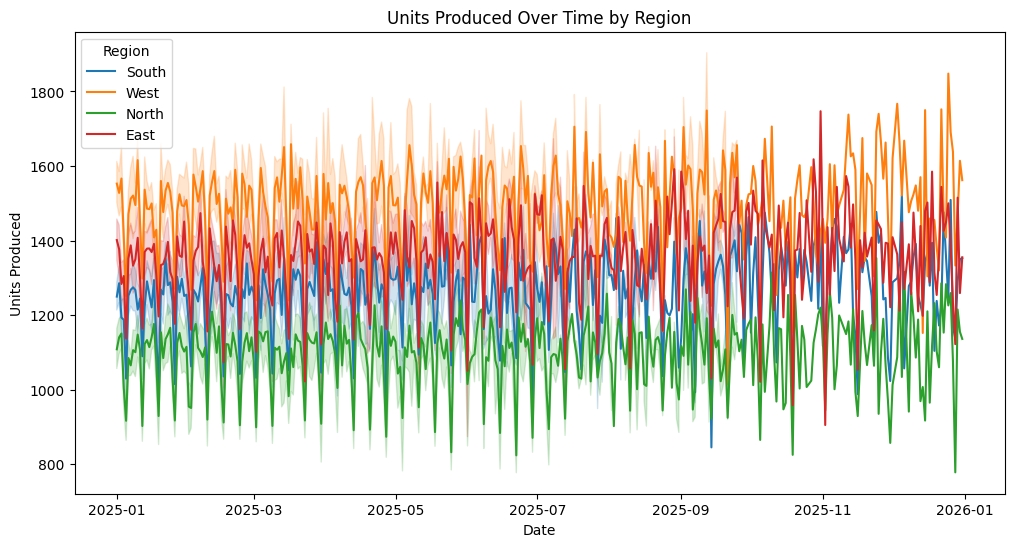

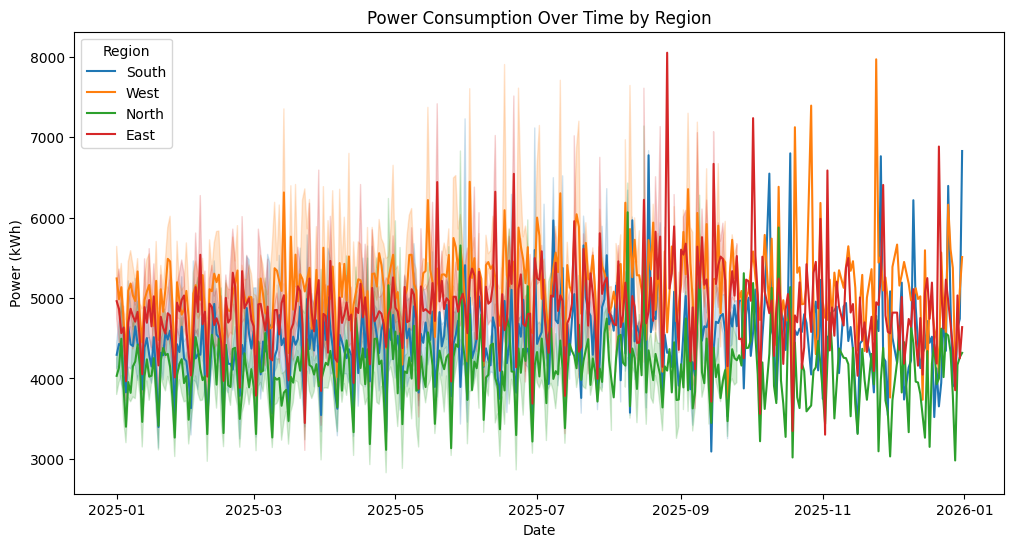

In [103]:
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='units_produced', hue='region', data=data)
plt.title("Units Produced Over Time by Region")
plt.xlabel("Date")
plt.ylabel("Units Produced")
plt.legend(title='Region')
plt.show()

plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='power_kwh', hue='region', data=data)
plt.title("Power Consumption Over Time by Region")
plt.xlabel("Date")
plt.ylabel("Power (kWh)")
plt.legend(title='Region')
plt.show()


#`DownTime comparision across region:-`

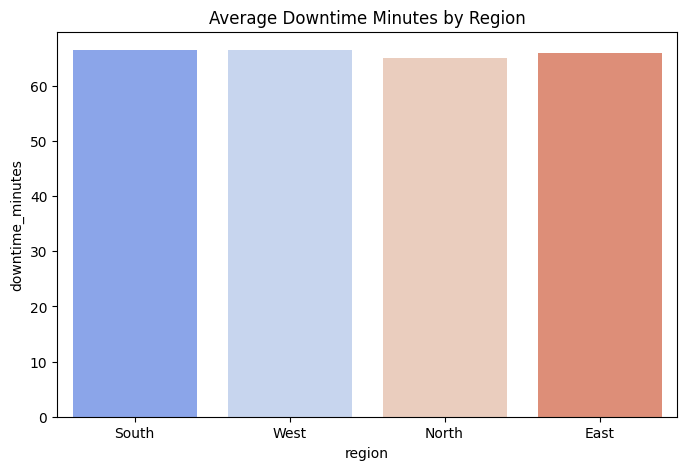

In [104]:
plt.figure(figsize=(8,5))
sns.barplot(x='region', y='downtime_minutes', data=data, ci=None, estimator=np.mean, palette='coolwarm')
plt.title("Average Downtime Minutes by Region")
plt.show()


#`Average Rainfall by Region:-`

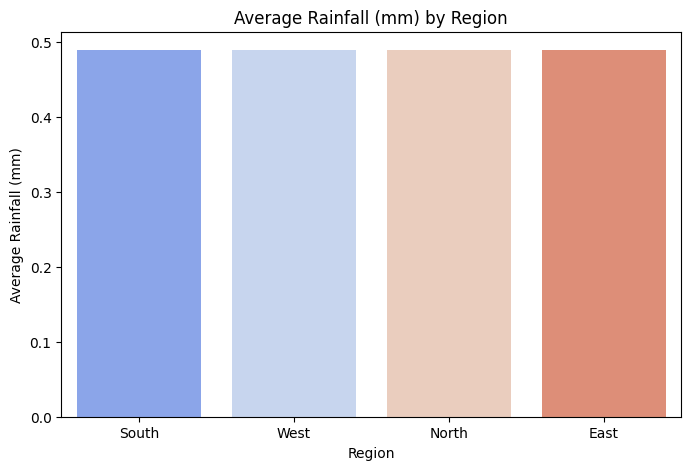

In [105]:
plt.figure(figsize=(8, 5))
sns.barplot(data=data, x='region', y='rainfall_mm', estimator='mean', ci=None, palette='coolwarm')
plt.title("Average Rainfall (mm) by Region")
plt.xlabel("Region")
plt.ylabel("Average Rainfall (mm)")
plt.show()

All most similar rainfall across region

#`Average price across region:-`

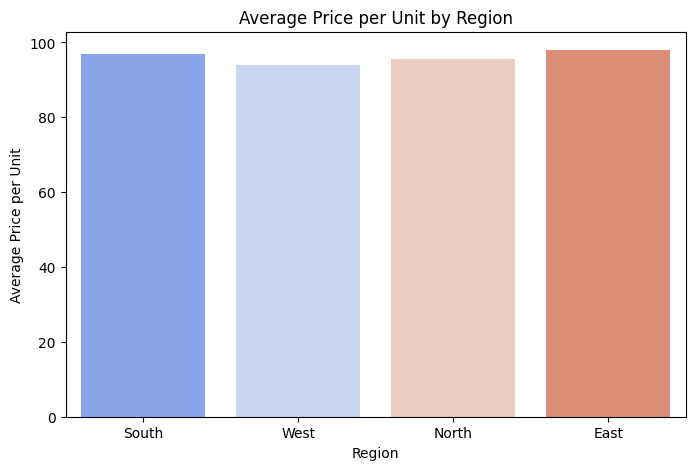

In [106]:
plt.figure(figsize=(8,5))
sns.barplot(data=data, x='region', y='price_per_unit', estimator='mean', ci=None, palette='coolwarm')
plt.title("Average Price per Unit by Region")
plt.xlabel("Region")
plt.ylabel("Average Price per Unit")
plt.show()

#`Month wise power consumption:-`

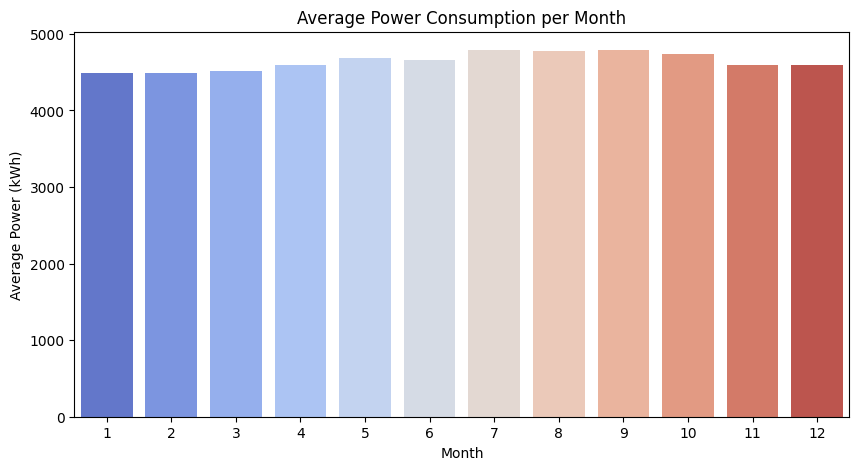

In [107]:
plt.figure(figsize=(10,5))
sns.barplot(data=data, x='month', y='power_kwh', estimator='mean', ci=None, palette='coolwarm')
plt.title("Average Power Consumption per Month")
plt.xlabel("Month")
plt.ylabel("Average Power (kWh)")
plt.show()

#`Drop the Site_id column as Region is similar column:-`

In [108]:
# Drop redundant site_id column
data.drop(columns=['site_id'], inplace=True)


In [109]:
data.shape

(5072, 20)

In [110]:
# Sort by date to maintain time order
data = data.sort_values("date")

#***Split the dataset:-***

In [111]:
# Use last 14 days as test (forecast horizon)
train_df = data.iloc[:-14]
test_df = data.iloc[-14:]

In [112]:
data.columns

Index(['date', 'units_produced', 'downtime_minutes', 'power_kwh',
       'rework_units', 'defects_ppm', 'staff_count', 'material_cost_per_unit',
       'price_per_unit', 'temperature_c', 'rainfall_mm', 'holiday_flag',
       'region', 'commissioned_year', 'shift_hours_per_day', 'site_age',
       'units_per_hour', 'power_per_unit', 'day_of_week', 'month'],
      dtype='object')

#`Select Features:-`

In [113]:
# Define feature columns (no leakage)
features = [
    'region', 'downtime_minutes', 'rework_units', 'defects_ppm',
    'staff_count', 'material_cost_per_unit', 'price_per_unit',
    'temperature_c', 'rainfall_mm', 'holiday_flag',
    'commissioned_year', 'shift_hours_per_day', 'site_age',
    'units_per_hour', 'power_per_unit', 'month', 'day_of_week'
]




#`two target column:-`

In [114]:
target_units = 'units_produced'
target_power = 'power_kwh'

X_train = train_df[features]
X_test = test_df[features]

y_train_units = train_df[target_units]
y_test_units = test_df[target_units]

y_train_power = train_df[target_power]
y_test_power = test_df[target_power]

#***Baseline Model:-***

In [115]:
# Label encode region
le = LabelEncoder()
X_train = X_train.copy()
X_test = X_test.copy()
X_train['region'] = le.fit_transform(X_train['region'])
X_test['region'] = le.transform(X_test['region'])

In [116]:
# Baseline model
baseline_model_units = LinearRegression()
baseline_model_power = LinearRegression()
#model fit
baseline_model_units.fit(X_train, y_train_units)
baseline_model_power.fit(X_train, y_train_power)

# Predictions baseline
y_pred_units_base = baseline_model_units.predict(X_test)
y_pred_power_base = baseline_model_power.predict(X_test)

#***Pipeline Model Structure:-***


1.   ARIMA/SARIMA(statsmodels) is not suitable for this multi-site, multi-feature dataset.
2.   So we use XGboost model in the pipline and label encoding.\
  Improved Model (XGBoost + Label Encoding Pipeline)






In [117]:
# Function for label encoding region
def label_encode_region(X):
    X = X.copy()
    X['region'] = le.fit_transform(X['region'])
    return X

In [118]:
# Build pipeline units
pipeline = Pipeline([
    ('label_encode', FunctionTransformer(label_encode_region)),
    ('model', XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbosity=0
    ))
])

#***Save the Model:-***

In [119]:
import joblib
# Train and predict for both targets
pipeline.fit(X_train, y_train_units)
y_pred_units_xgb = pipeline.predict(X_test)

# Save the model for units_produced
joblib.dump(pipeline, 'xgb_units_model.pkl')

['xgb_units_model.pkl']

In [120]:
# Train and predict for power_kwh
pipeline.fit(X_train, y_train_power)
y_pred_power_xgb = pipeline.predict(X_test)

# Save the model for power_kwh
joblib.dump(pipeline, 'xgb_power_model.pkl')

['xgb_power_model.pkl']

#***Evaluate Both Models (MAE / MAPE):-***

In [121]:
# Evaluation function
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{label} → MAE: {mae:.2f}, MAPE: {mape*100:.2f}%")
    return mae, mape

In [122]:
print("=== Baseline Model (Linear Regression) ===")
evaluate_model(y_test_units, y_pred_units_base, "Units Produced")
evaluate_model(y_test_power, y_pred_power_base, "Power kWh")

=== Baseline Model (Linear Regression) ===
Units Produced → MAE: 7.80, MAPE: 0.60%
Power kWh → MAE: 58.49, MAPE: 1.17%


(58.48819002579798, 0.011735349095855196)

In [123]:
print("\n=== Improved Model (XGBoost Pipeline) ===")
evaluate_model(y_test_units, y_pred_units_xgb, "Units Produced")
evaluate_model(y_test_power, y_pred_power_xgb, "Power kWh")


=== Improved Model (XGBoost Pipeline) ===
Units Produced → MAE: 0.71, MAPE: 0.05%
Power kWh → MAE: 32.44, MAPE: 0.62%


(32.44189453125, 0.006199992727488279)

In [124]:
# Combine into one DataFrame for easy plotting
results = pd.DataFrame({
    'date': test_df['date'],
    'actual_units': y_test_units,
    'pred_units': y_pred_units_xgb,
    'actual_power': y_test_power,
    'pred_power': y_pred_power_xgb
}).sort_values('date')

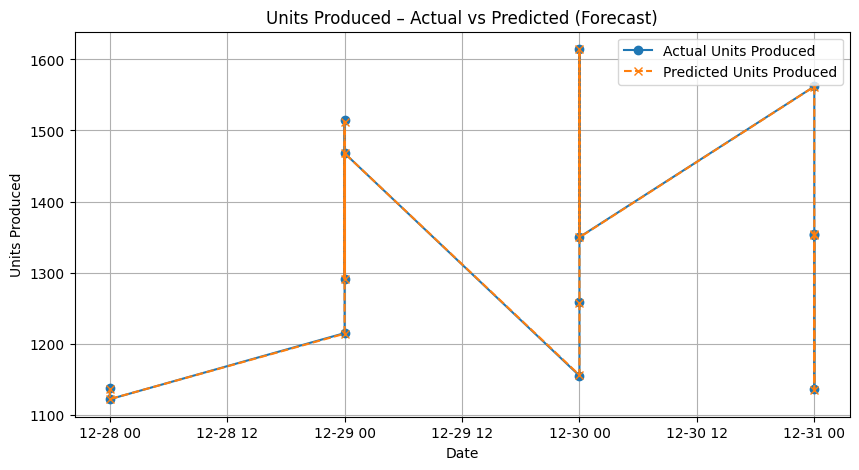

In [125]:
# Plot Units Produced Forecast
plt.figure(figsize=(10, 5))
plt.plot(results['date'], results['actual_units'], label='Actual Units Produced', marker='o')
plt.plot(results['date'], results['pred_units'], label='Predicted Units Produced', linestyle='--', marker='x')
plt.title('Units Produced – Actual vs Predicted (Forecast)')
plt.xlabel('Date')
plt.ylabel('Units Produced')
plt.legend()
plt.grid(True)
plt.show()

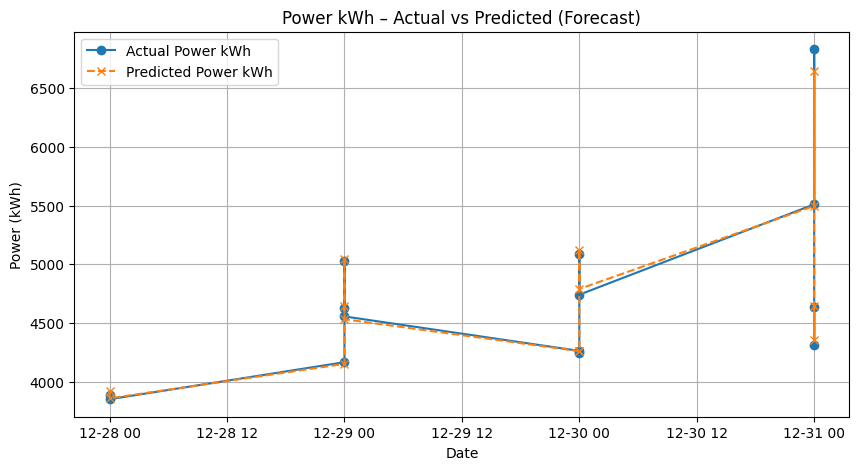

In [126]:
# Plot Power kWh Forecast
plt.figure(figsize=(10, 5))
plt.plot(results['date'], results['actual_power'], label='Actual Power kWh', marker='o')
plt.plot(results['date'], results['pred_power'], label='Predicted Power kWh', linestyle='--', marker='x')
plt.title('Power kWh – Actual vs Predicted (Forecast)')
plt.xlabel('Date')
plt.ylabel('Power (kWh)')
plt.legend()
plt.grid(True)
plt.show()

#**Save Forecast Results:-**

In [127]:
forecast_results = test_df[['date', 'region']].copy()
forecast_results['forecast_units_produced'] = y_pred_units_xgb
forecast_results['forecast_power_kwh'] = y_pred_power_xgb

forecast_results.to_csv('forecast_results.csv', index=False)
print("Forecast results saved to outputs/forecast_results.csv")


Forecast results saved to outputs/forecast_results.csv
